In [1]:
from Contour import ContourData

# Run with the subset test data

In [60]:
cd = ContourData(
        filepath = 'WellElevationSubsetSmaller.xlsx',
        xcol = 'X',
        ycol = 'Y',
        zcol = "Water Elevation(ft NAVD88)",
        tcol = "DateTimeRounded",
        crs = 2926,
        method = 'linear',
        steps = 50
)

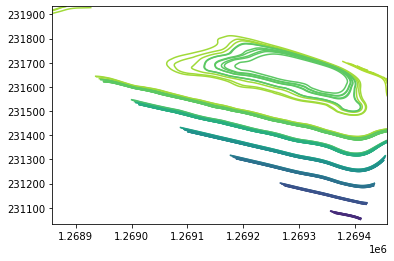

In [61]:
cd.subsetData()
cd.contourData(subdivisions=5)
cd.extractGeometry()
cd.mergeGeometry()
cd.reproject()
cd.toGeoJSON("test.json")

# Run on data with no Observation wells yet

In [131]:
cd = ContourData(
        filepath = 'WellElevations4hour.xlsx',
        xcol = 'X',
        ycol = 'Y',
        zcol = "Water Elevation(ft NAVD88)",
        tcol = "DateTimeRounded",
        crs = 2926,
        method = 'tri',
        
)

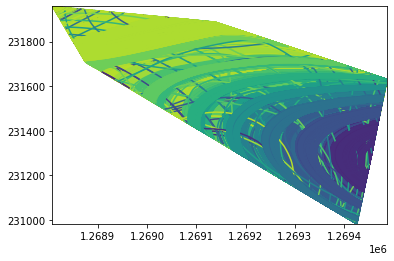

In [132]:
cd.subsetData()
cd.contourData(subdivisions=5)
cd.extractGeometry()
cd.mergeGeometry()
cd.reproject()
cd.toGeoJSON("Contours4hour.json")